In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !cp /content/drive/My\ Drive/Datasets/digit-recognizer.zip /content
# !unzip digit-recognizer.zip
# ! rm -rf sample_data digit-recognizer.zip
# !rm -rf test.csv
# !rm -rf sample_submission.csv

In [0]:
data_df = pd.read_csv('train.csv')

In [0]:
X = data_df.drop(['label'], axis = 1)
Y = data_df['label']

In [0]:
# Normalize the input images
X = X.to_numpy() / 255.0
# One hot encode the labels
Y = pd.get_dummies(Y.to_numpy()).to_numpy()

In [0]:
# Resize in shape of (m, h, w, c) for CNN
X = X.reshape(-1, 28, 28, 1)

In [8]:
print (X.shape)
print (Y.shape)

(42000, 28, 28, 1)
(42000, 10)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.12)

In [10]:
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

(36960, 28, 28, 1)
(36960, 10)
(5040, 28, 28, 1)
(5040, 10)


In [0]:
n_classes, image_size, n_channels = 10, 28, 1

In [0]:
def conv_relu(inp, filter_size, n_filter):
    weights = tf.get_variable(name = 'weights', shape = [filter_size, filter_size, inp.shape[3], n_filter], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name = 'biases', shape = [n_filter], initializer = tf.zeros_initializer())
    conv = tf.nn.conv2d(input = inp, filter = weights, strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(tf.add(conv, biases))  

def max_pool(inp, filter_size):
    return tf.nn.max_pool(value=inp, ksize=[1, filter_size, filter_size, 1], strides=[1, filter_size, filter_size, 1], padding = 'SAME')

def fully_connected(inp, n_neurons):
    weights = tf.get_variable(name = 'weights', shape = [inp.shape[1], n_neurons], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name = 'biases', shape = [n_neurons], initializer=tf.zeros_initializer())

    return tf.add(tf.matmul(inp, weights), biases)

def fully_connected_relu(inp, n_neurons):
    return tf.nn.relu(fully_connected(inp, n_neurons))

def dropout(inp, dropout_rate = 0.2):
    return tf.nn.dropout(x=inp, rate=dropout_rate, seed = 28) # rate is 1 - keep_prob

In [0]:
# Get placeholders for X and Y with batch size as variable parameter
def get_placeholders():
    X = tf.placeholder(name='X', shape=[None, image_size, image_size, n_channels], dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape = [None, n_classes], dtype=tf.float32) # One hot encoded size of Y
    is_training = tf.placeholder(name='is_training', dtype=tf.bool)
    return X, Y, is_training

In [0]:
def cnn_forward_propagate(data, is_training):

    # Adding first convolution layer
    with tf.variable_scope(name_or_scope='conv0', reuse=tf.AUTO_REUSE):
        conv = conv_relu(data, filter_size=3, n_filter=64)
        pool = max_pool(conv, filter_size = 2)
        # pool = tf.cond(is_training, lambda: dropout(pool, 0.2), lambda: pool)
        
    # # Adding second convolution layer
    # with tf.variable_scope(name_or_scope='conv1', reuse=tf.AUTO_REUSE):
    #     conv = conv_relu(pool, filter_size = 2, n_filter = 64)
    #     pool = max_pool(conv, filter_size = 2)
    #     # pool = tf.cond(is_training, lambda: dropout(pool, 0.2), lambda: pool)

    # # Adding third convolution layer
    # with tf.variable_scope(name_or_scope='conv2'):
    #     conv = conv_relu(pool, filter_size=2, n_filter=128)
    #     pool = max_pool(conv, filter_size=2)
    #     # pool = tf.cond(is_training, lambda: dropout(pool, 0.2), lambda: pool)

    # Flatten the output for inject it in fully connected layer
    shapes = pool.get_shape().as_list()
    flattened = tf.reshape(pool, [-1, shapes[1] * shapes[2] * shapes[3]])
    
    # Adding fully connected layer of size 16
    with tf.variable_scope(name_or_scope='fc0', reuse=tf.AUTO_REUSE):
        fc_relu = fully_connected_relu(flattened, 32)
    
    # # Adding another fully connected layer with 16 neurons
    # with tf.variable_scope(name_or_scope='fc1', reuse=tf.AUTO_REUSE):
    #     fc_relu = fully_connected_relu(fc_relu, 16)

    # Output layer with 10 neurons (n_classes = 10)
    with tf.variable_scope(name_or_scope='output', reuse=tf.AUTO_REUSE):
        logits = fully_connected(fc_relu, n_classes)
    
    return logits

In [0]:
def calculate_loss(labels, logits):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))

In [0]:
def get_random_minibatches(X, Y, minibatch_size = 64, seed = 28):
    import math
    # First set the seed
    np.random.seed(seed)
    m = X.shape[0]
    minibatches = []

    # Then get the permutation of indices and using that, shuffel X and Y
    permutation = list(np.random.permutation(m))
    X = X[permutation, :, :, :]
    Y = Y[permutation, :].reshape(m, Y.shape[1])

    # Now get minibatches from shuffeled X and Y
    n_complete_minibatches = math.floor(m / minibatch_size)

    # Get all complete minibatches
    for index in range(n_complete_minibatches):
        minibatch_X = X[index * minibatch_size : (index + 1) * minibatch_size, :, :, :]
        minibatch_Y = Y[index * minibatch_size : (index + 1) * minibatch_size, :]
        minibatches.append((minibatch_X, minibatch_Y))

    # Now handle the case of last incomplete minibatch
    if not (m % minibatch_size == 0):
        minibatch_X = X[n_complete_minibatches * minibatch_size: , :, :, :]
        minibatch_Y = Y[n_complete_minibatches * minibatch_size: , :]
        minibatches.append((minibatch_X, minibatch_Y))

    return minibatches

In [0]:
def cnn_model(X_train, Y_train, X_test, Y_test, learning_rate = 0.02, n_epochs = 10, minibatch_size = 32):

    tf.reset_default_graph()

    X, Y, is_training = get_placeholders()
    
    # Forward propagate through CNN
    logits = cnn_forward_propagate(X, is_training=is_training)

    # Calculate the cost
    cost = calculate_loss(Y, logits)

    # Define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initialize all tf variables
    init = tf.global_variables_initializer()
    costs, m = [], X_train.shape[0]

    with tf.Session() as session:
        session.run(init)
        
        for epoch in range(n_epochs):
            n_minibatches, batch_cost = m // minibatch_size, 0
            minibatches = get_random_minibatches(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                xb, yb = minibatch
                _, minibatch_cost = session.run([optimizer, cost], feed_dict = {X: xb, Y: yb, is_training: True})
                batch_cost += minibatch_cost / n_minibatches
            costs.append(batch_cost)
            print (f'Costs after {epoch} epochs: {batch_cost}')
        
        x1 = tf.placeholder(name = 'x1', shape = [None, 28, 28, 1], dtype = tf.float32)
        y1 = tf.placeholder(name = 'y1', shape = [None, 10], dtype = tf.float32)
        
        correct_preds = tf.equal(tf.argmax(cnn_forward_propagate(x1, tf.constant(False, dtype=tf.bool)), axis = 1), tf.argmax(y1, axis = 1))
        accuracy = tf.reduce_mean(tf.cast(correct_preds, dtype= 'float'))
        train_acc = session.run(accuracy, feed_dict = {x1: X_train, y1: Y_train})
        test_acc = session.run(accuracy, feed_dict = {x1: X_test, y1: Y_test})

        print (f'Training set Accuracy: {train_acc * 100}')
        print (f'Dev set Accuracy: {test_acc * 100}')

        return costs

In [35]:
costs = cnn_model(X_train, Y_train, X_test, Y_test, learning_rate=0.02)

Costs after 0 epochs: 0.2106031302860595
Costs after 1 epochs: 0.11452936458479998
Costs after 2 epochs: 0.10847841451986238
Costs after 3 epochs: 0.09341808373282345
Costs after 4 epochs: 0.09205394123252807
Costs after 5 epochs: 0.08836513661407262
Costs after 6 epochs: 0.082242335551657
Costs after 7 epochs: 0.09018467126903362
Costs after 8 epochs: 0.08045991059465857
Costs after 9 epochs: 0.08266968180889328
Training set Accuracy: 98.82846474647522
Dev set Accuracy: 96.50793671607971


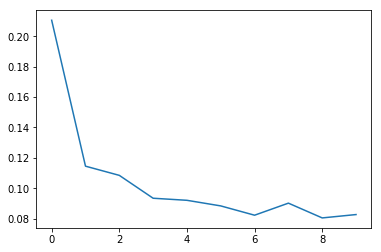

In [36]:
plt.plot(costs)
plt.show()